In [28]:
import pandas as pd
import glob
import seaborn as sns

## funtion for pipe 

In [2]:

def get_only_uniprot_accession(df, colname):
    
    colname_out = colname + '_uniprot_accession'
    
    df[colname_out] = df[colname].str.split('-', expand=True)[1]
    
    return df


def calc_coverage(df, which_one ,start, end, lenght):
    
    col_name = 'COV_' + which_one
    
    df[col_name] = (df.loc[: , end] - df.loc[: , start]) / df.loc[: , lenght]
    
    df[col_name] = df[col_name].round(2)
    
    return df

## concatenating all tsv data frames 

In [3]:
list_of_df = []
for file in glob.glob('../../../report_files/reciprocal_best_hit_TSV/*.tsv'):
    
    df = pd.read_csv(file, sep='\t', names=['query','target','alnlen','fident', 'evalue', 'qstart','qend', 'qlen','tstart','tend','tlen'])
    
    #info from file name
    info = file.split('_')[-4:-1]
    df['proteome'] = info[0]
    df['spp'] = info[-1]
    
    #appending_list
    list_of_df.append(df)
    #print(file)

In [4]:
df = pd.concat(list_of_df)

In [16]:
len(list_of_df)

48

## df inspection and cheking
* some target are duplicated because they have a .pdb and .cif file. -> remove .cif if there is allready a .pdb #rbh return both so is not a problem for the analysis.
* some ortho groups from single members have the same structure assigned by tritrypDB. So we will find them duplicated.

In [6]:
df = (df
 .pipe(get_only_uniprot_accession, 'query')
 .pipe(get_only_uniprot_accession, 'target')
 .pipe(calc_coverage, 'query', 'qstart', 'qend','qlen')
 .pipe(calc_coverage, 'target', 'tstart', 'tend','tlen'))

print(df.shape)

df = df.drop_duplicates(['query_uniprot_accession', 'target_uniprot_accession'])

print(df.shape)

(226912, 17)
(138904, 17)


In [68]:

#dataframe with GO annotation informattion
df_gene_information = pd.read_csv('../../../tmp/GenesByOrthologPattern_Summary.txt',
                                  sep='\t',
                                  low_memory=False)

ortho_g_count = df_gene_information.groupby('Ortholog Group').size().to_frame()
ortho_g_count = ortho_g_count[ortho_g_count[0] > 10]

## Amount of cluster with rbh result 

In [69]:
df_ogup = pd.read_csv('../../../report_files/ortholog_groups_x_sequence_clustering_x_UNIPROT.tsv', sep='\t')

In [70]:
df_ogup = df_ogup[~df_ogup.uniprot.isna()]

In [71]:
print('Total amount of cluster to annotate:')
print(df_ogup.Ortholog_Group.nunique())

Total amount of cluster to annotate:
30915


In [72]:
#merging df 
df_merged = df_ogup.merge(df, left_on='uniprot', right_on='query_uniprot_accession', how='right')

In [79]:
print('Total amount of cluster with hit in rbh approach:')
print(df_merged.Ortholog_Group.nunique())

Total amount of cluster with hit in rbh approach:
24012


24012


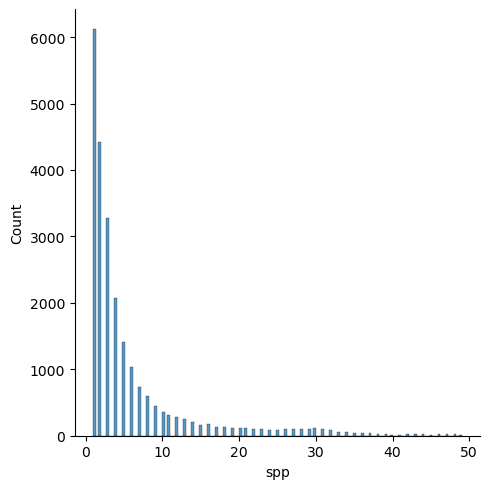

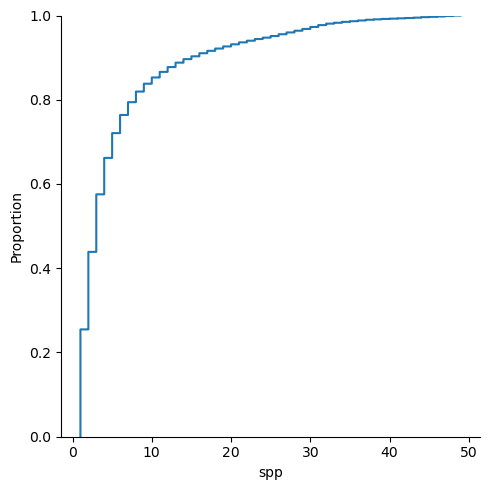

In [93]:
data = df_merged.groupby('Ortholog_Group')['spp'].count()

#data = data[data >= 10]

print(len(data.index))

sns.displot(data=data)
sns.displot(data=data,kind='ecdf')

In [ ]:
sns.scatterplot(data = df_merged, x='pLDDT_mean', y='')

In [98]:
df_merged[(df_merged['pLDDT_mean'] < 60 ) & (df_merged['Gene ID'].str.contains('Tb'))] #[df_merged['Ortholog_Group'] == 'OG6r16_102156'].sort_values('fident')

,Ortholog_Group,Gene ID,uniprot,pLDDT_mean,query,target,alnlen,fident,evalue,qstart,...,qlen,tstart,tend,tlen,proteome,spp,query_uniprot_accession,target_uniprot_accession,COV_query,COV_target
379,OG6_136949,Tb427.07.2630,Q57XL1,54.0,AF-Q57XL1-F1-model_v4.pdb,AF-A0A1D8PCY5-F1-model_v4.cif.gz,101,0.119,3.451000e-05,199,...,900,0,380,397,UP000000559,CANAL,Q57XL1,A0A1D8PCY5,0.31,0.96
409,OG6r16_147933,Tbg972.11.17140,D0AA93,40.0,AF-D0AA93-F1-model_v4.pdb,AF-Q5A512-F1-model_v4.pdb.gz,31,0.198,6.546000e-02,0,...,114,0,106,107,UP000000559,CANAL,D0AA93,Q5A512,0.99,0.99
432,OG6_223517,Tb927.10.14270,Q388H5,54.0,AF-Q388H5-F1-model_v4.pdb,AF-Q5A7R0-F1-model_v4.pdb.gz,284,0.146,2.133000e-13,111,...,677,0,436,441,UP000000559,CANAL,Q388H5,Q5A7R0,0.81,0.99
652,OG6_106744,Tb927.7.5380,Q582F3,53.0,AF-Q582F3-F1-model_v4.pdb,AF-A0A1D8PQM1-F1-model_v4.pdb.gz,317,0.197,1.597000e-21,111,...,599,0,352,436,UP000000559,CANAL,Q582F3,A0A1D8PQM1,0.66,0.81
1105,OG6r16_510981,Tbg972.7.5696,C9ZTD2,37.0,AF-C9ZTD2-F1-model_v4.pdb,AF-A0A1D8PJG0-F1-model_v4.pdb.gz,37,0.100,1.340000e-01,0,...,113,0,104,109,UP000000559,CANAL,C9ZTD2,A0A1D8PJG0,0.94,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140375,OG6_388956,Tbg972.5.130,C9ZN97,47.0,AF-C9ZN97-F1-model_v4.pdb,AF-A0A133CNV6-F1-model_v4.pdb.gz,89,0.324,9.171000e-04,127,...,293,7,77,85,UP000325664,ENTFC,C9ZN97,A0A133CNV6,0.24,0.82
140500,OG6r16_147945,Tbg972.9.9110,C9ZZI6,32.0,AF-C9ZZI6-F1-model_v4.pdb,AF-A0A1M2WJM2-F1-model_v4.pdb.gz,41,0.135,1.809000e-01,3,...,134,0,56,60,UP000325664,ENTFC,C9ZZI6,A0A1M2WJM2,0.42,0.93
140520,OG6_389313,Tbg972.8.4250,C9ZVP5,30.0,AF-C9ZVP5-F1-model_v4.pdb,AF-A0A0M1PBF1-F1-model_v4.cif.gz,31,0.115,3.607000e-01,189,...,451,1,70,71,UP000325664,ENTFC,C9ZVP5,A0A0M1PBF1,0.16,0.97
140748,OG6_389077,Tb927.11.13160,Q382M0,34.0,AF-Q382M0-F1-model_v4.pdb,AF-A0A5P3FTA1-F1-model_v4.pdb.gz,46,0.086,4.801000e-02,21,...,227,35,133,136,UP000325664,ENTFC,Q382M0,A0A5P3FTA1,0.50,0.72


In [25]:
df_merged[df_merged['Ortholog_Group'] == 'OG6_100266'].sort_values('fident')

,Ortholog_Group,Gene ID,uniprot,pLDDT_mean,query,target,alnlen,fident,evalue,qstart,...,qlen,tstart,tend,tlen,proteome,spp,query_uniprot_accession,target_uniprot_accession,COV_query,COV_target
135284,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-A0A0H3GU14-F1-model_v4.pdb.gz,124,0.192,2.458000e-04,21,...,144,23,115,117,UP000007841,KLEPH,A0A0N0DZL4,A0A0H3GU14,0.67,0.79
134129,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-P9WH65-F1-model_v4.pdb.gz,419,0.272,4.180000e-14,0,...,144,4,138,139,UP000001584,MYCTU,A0A0N0DZL4,P9WH65,0.99,0.96
99845,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-K0ENE8-F1-model_v4.pdb.gz,391,0.275,5.051000e-13,0,...,144,0,136,137,UP000006304,9NOCA1,A0A0N0DZL4,K0ENE8,0.99,0.99
132753,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-Q9X7A0-F1-model_v4.pdb.gz,420,0.292,3.137000e-14,0,...,144,3,137,138,UP000000806,MYCLE,A0A0N0DZL4,Q9X7A0,0.99,0.97
79133,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-X8FIH5-F1-model_v4.pdb.gz,227,0.295,4.550000e-07,35,...,144,1,96,98,UP000020681,MYCUL,A0A0N0DZL4,X8FIH5,0.72,0.97
80694,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-P56018-F1-model_v4.pdb.gz,395,0.297,3.319000e-13,0,...,144,0,129,131,UP000000429,HELPY,A0A0N0DZL4,P56018,0.97,0.98
85434,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-Q9PM82-F1-model_v4.pdb.gz,402,0.304,2.312000e-13,0,...,144,0,128,130,UP000000799,CAMJE,A0A0N0DZL4,Q9PM82,0.97,0.98
140146,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-A0A0M1PG85-F1-model_v4.pdb.gz,397,0.307,6.543000e-13,0,...,144,0,127,129,UP000325664,ENTFC,A0A0N0DZL4,A0A0M1PG85,0.97,0.98
110974,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-P66360-F1-model_v4.pdb.gz,422,0.307,1.769000e-13,0,...,144,0,125,127,UP000000586,STRR6,A0A0N0DZL4,P66360,0.97,0.98
87766,OG6_100266,LpyrH10_02_7100,A0A0N0DZL4,92.0,AF-A0A0N0DZL4-F1-model_v4.pdb,AF-Q5F5V0-F1-model_v4.pdb.gz,412,0.308,1.280000e-13,0,...,144,0,130,131,UP000000535,NEIG1,A0A0N0DZL4,Q5F5V0,0.99,0.99
